<a href="https://colab.research.google.com/github/AlekseyBuzmakov/2023-TextAI/blob/word2vec/2023_TextAI_Word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

План:
- [X] Пример:
    - [X] Брать вектор
    - [X] most_similar
- [ ] Работа с предобученной моделью
    - [ ] Чистка данных
    - [ ] Базовое предсказание
- [ ] Обучение своей
    - [ ] Skip-grams (SG)
    - [ ] Continuous-bag-of-words (CBOW)

In [ ]:
import sys
sys.version

'3.9.16 (main, Dec  7 2022, 01:11:51) \n[GCC 9.4.0]'

# Работа с данными



In [ ]:
!gdown 1_qz6EISp2bvK1zp3U6IfzYyOXyaEX3-o

Downloading...
From: https://drive.google.com/uc?id=1_qz6EISp2bvK1zp3U6IfzYyOXyaEX3-o
To: /content/data.csv.zip
100% 83.9M/83.9M [00:00<00:00, 254MB/s]


In [ ]:
import math
import random
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
import gensim

from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm

from collections import Counter

tqdm.pandas()
random.seed(42)
np.random.seed(42)

<ipython-input-3-ef2f618029f9>:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Загрузка данных

In [ ]:
data = pd.read_csv("data.csv.zip", index_col="id")
data.head()

,emotion,date,flag,user,text
id,,,,,
1467810369,0,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1467810672,0,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1467810917,0,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
1467811184,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
1467811193,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data["date"] = pd.to_datetime(data["date"].str.replace(" PDT ", " "), format="%a %b %d %H:%M:%S %Y")
data.head()

,emotion,date,flag,user,text
id,,,,,
1467810369,0,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1467810672,0,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1467810917,0,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
1467811184,0,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
1467811193,0,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 1467810369 to 2193602129
Data columns (total 5 columns):
 #   Column   Non-Null Count    Dtype         
---  ------   --------------    -----         
 0   emotion  1600000 non-null  int64         
 1   date     1600000 non-null  datetime64[ns]
 2   flag     1600000 non-null  object        
 3   user     1600000 non-null  object        
 4   text     1600000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 73.2+ MB


<Axes: xlabel='emotion', ylabel='count'>

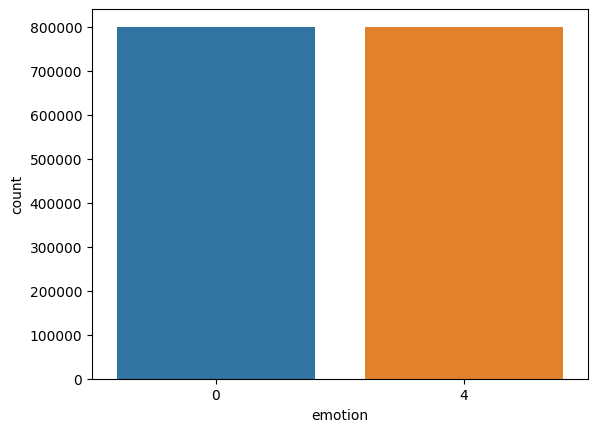

In [ ]:
sns.countplot(data=data, x="emotion")

## Чистка текста

In [ ]:
PUNCT_TO_REMOVE = string.punctuation + "«»№"
URL_PATTERN = r'https?://\S+|www\.\S+' # https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)
HTML_PATTERN = '<.*>'
USERNAME_PATTERN = "@\w+\s"
DIGIT_PATTERN = "\d+"
regex_pattern = re.compile(f"({URL_PATTERN}|{HTML_PATTERN}|{USERNAME_PATTERN}|{DIGIT_PATTERN})")

In [ ]:
example_text = data.iloc[0, -1]

text = regex_pattern.sub("", example_text).split()
text = [i.translate(str.maketrans(PUNCT_TO_REMOVE, ' '*len(PUNCT_TO_REMOVE))) for i in text]
text = [''.join(i for i in word if not i.isdigit()) for word in text]

example_text, " ".join(text)

("@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 '  Awww  that s a bummer  You shoulda got David Carr of Third Day to do it   D')

In [ ]:
# test = []
# for index, row in tqdm(data.iterrows(), total=data.shape[0]):
#     text = regex_pattern.sub("",row["text"]).split()
#     text = [i.translate(str.maketrans(PUNCT_TO_REMOVE, ' '*len(PUNCT_TO_REMOVE))) for i in text]
#     text = [''.join(i for i in word if not i.isdigit()) for word in text]
#     text = " ".join(text)
#     test.append(text)
#     data.at[index, "text"] = text

In [ ]:
cnt = Counter()

def clean_words(row) -> str:
    text = row["text"].lower()
    text = regex_pattern.sub("", text).split()
    text = [i.translate(str.maketrans(PUNCT_TO_REMOVE, ' '*len(PUNCT_TO_REMOVE))) for i in text]
    text = [''.join(i for i in word if not i.isdigit()) for word in text]

    for word in text:
        cnt[word] += 1
    return " ".join(text)

In [ ]:
data["text"] = data.progress_apply(clean_words, axis=1)

  0%|          | 0/1600000 [00:00<?, ?it/s]

## Распространенные слова


In [ ]:
cnt.most_common(10)

[('i', 746610),
 ('to', 560333),
 ('the', 518757),
 ('a', 377257),
 ('my', 312864),
 ('and', 295634),
 ('you', 237750),
 ('is', 231041),
 ('for', 214049),
 ('in', 210083)]

In [ ]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["text"])

CPU times: user 22.4 s, sys: 486 ms, total: 22.8 s
Wall time: 23 s


In [ ]:
X.shape

(1600000, 286750)

In [ ]:
X = pd.Series(sorted(np.squeeze(np.asarray((X != 0).sum(axis=0)))))
X[-10:]

286740    170395
286741    199622
286742    201562
286743    219734
286744    244485
286745    261769
286746    272040
286747    282511
286748    427819
286749    458172
dtype: int64

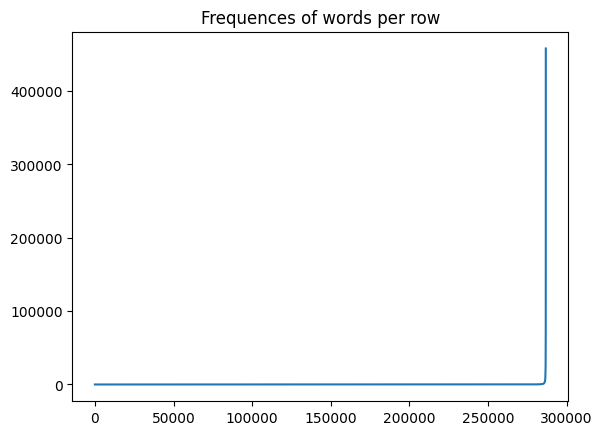

In [ ]:
plt.plot(X)
plt.title("Frequences of words per row");

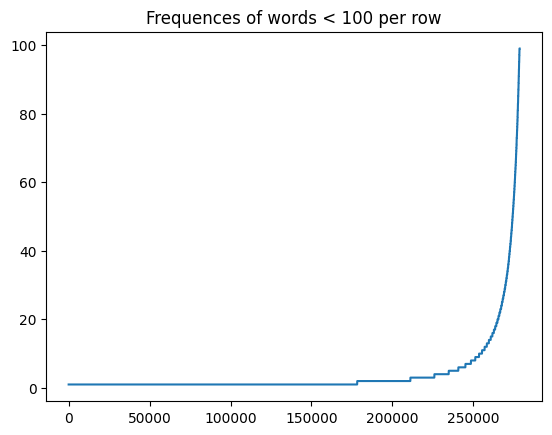

In [ ]:
plt.plot(X[X<100])
plt.title("Frequences of words < 100 per row");

# TODO Удалять слова?

In [ ]:
X = None
cnt = None

# Word2Vec


## Примеры Word2Vec

In [ ]:
%%time
from gensim import downloader

wv = downloader.load('word2vec-google-news-300')

CPU times: user 1min, sys: 4.39 s, total: 1min 5s
Wall time: 1min 6s


In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


![](https://raw.githubusercontent.com/amanjeetsahu/Natural-Language-Processing-Specialization/d562105e68a0b85012ad3ebbb29b2af6344ad4e5/Natural%20Language%20Processing%20with%20Classification%20and%20Vector%20Spaces/Week%203/vectors.jpg)

$$cos(X,Y) = \frac{<X, Y>}{||X||*||Y||}$$

Поиск ближайших соседей из примера с помощью gensim

In [ ]:
wv.most_similar(positive=['king', "woman"], negative=["man"], topn=5) # cosine similarity

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581)]

Рассчет схожести известных слов с помощью sklearn



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
computed_vector = [wv["king"]-wv["man"]+wv["woman"]]
intresting_words = ["queen", "monarch", "princess"]
for word, result in zip(intresting_words, cosine_similarity(computed_vector, wv[intresting_words])[0]):
    print(f"Result for {word=} is {result=}")

Result for word='queen' is result=0.73005176
Result for word='monarch' is result=0.64546615
Result for word='princess' is result=0.6156252


Рассчет схожести известных слов на numpy

In [ ]:
(computed_vector @ wv["queen"]) / (np.linalg.norm(computed_vector) * np.linalg.norm(wv["queen"]))

array([0.73005176], dtype=float32)

Тренируемся на котятах и щенках
![](https://petstory.ru/resize/800x800x80/upload/images/articles//kotyenok-i-shchenok-v-odnoy-kvartire/kitt-and-pupp1.jpg)

In [ ]:
# Для примера

wv.most_similar(positive=["puppy", "cat"], negative=["dog"], topn=5)

[('kitten', 0.7634989619255066),
 ('puppies', 0.7110899686813354),
 ('pup', 0.6929494142532349),
 ('kittens', 0.6888390779495239),
 ('cats', 0.6796489357948303)]

## Применение Word2Vec

Тк будут классифицироваться твиты, то надо получать эмбединг самого твита. В данном случае будут усредняться все слова для которых известен вектор.

In [ ]:
emb_line = np.mean([wv.get_vector(w) for w in data.iloc[0, -1].split() if w in wv], axis=0)
print(emb_line.shape)
print(emb_line)

(300,)
[ 0.01497105  0.01365539 -0.01768276  0.17776926 -0.06657628 -0.03283909
 -0.03889247 -0.08829171  0.05092076  0.07562474 -0.08740889 -0.13777815
 -0.05225481  0.00619071 -0.07143729  0.0819724   0.09817941  0.1179548
 -0.04559653 -0.1156965  -0.11109529  0.07343102  0.17407227 -0.09913854
 -0.00827571 -0.04022435 -0.07413591  0.02731214 -0.02598245 -0.01106032
 -0.06823076  0.06035941 -0.01707022 -0.05290004 -0.05621937 -0.02054705
 -0.01516724  0.06623296 -0.03253283  0.08760071  0.03864397 -0.1003418
  0.23293631 -0.00732858 -0.02327619  0.01831491 -0.02643694 -0.11656625
  0.0624564   0.02959987 -0.14591326  0.05016     0.05267988  0.10173253
  0.02105713  0.10768019 -0.04174369 -0.09200178  0.06279319 -0.04637473
 -0.04540062  0.11249433 -0.05984006 -0.03186253 -0.00772095 -0.14575632
 -0.08989225 -0.00315203 -0.0589992   0.09278215  0.11464582  0.04915074
  0.00921631  0.01085772 -0.17524937 -0.00368827  0.06352125  0.10571289
  0.03891972  0.09274728 -0.07488142 -0.035330

In [ ]:
mean = np.mean(wv.vectors, 0)
std = np.std(wv.vectors, 0)

emb_line = np.mean([(wv.get_vector(w) - mean) / std for w in data.iloc[0, -1].split() if w in wv], axis=0)
print(emb_line.shape)
print(emb_line)

(300,)
[ 0.12441395  0.11959733 -0.05962821  1.1291173  -0.5650362   0.11360583
 -0.38069126 -0.37698087  0.19789647  0.23377113 -0.7218544  -1.101671
 -0.22392257 -0.2805214  -0.24863079  0.4292507   0.61467063  0.6615648
 -0.15875371 -0.8650853  -1.1350769   0.53863037  0.90458333 -1.0204123
 -0.10251779 -0.0969864  -0.33185482 -0.12866603 -0.30854607  0.2684019
 -0.3084691   0.8341306  -0.18025717 -0.19610699 -0.48523757  0.40046695
 -0.42268327  0.48725367 -0.29552412  0.5816415   0.37858394 -0.58082104
  1.4224008  -0.46938905  0.18081352  0.739817    0.14306934 -0.878883
  0.41129187 -0.10025807 -0.57050467  0.09678835  0.38400382  0.85469335
  0.36761206  0.45847896  0.1272875  -0.5214959   0.6478004   0.18370898
  0.03259028  0.524264   -0.06493772 -0.29720333 -0.12877987 -0.84021884
 -0.64140064 -0.14098121 -0.8905572   0.21701737  0.814106    0.63209444
 -0.04547229 -0.07371013 -0.52076775  0.43831554  0.29870334  1.3430119
 -0.01936653  0.57618695 -0.48487523  0.10079814 -0.

In [ ]:
mean = np.mean(wv.vectors, 0)
std = np.std(wv.vectors, 0)

def compute_embedding(row) -> np.ndarray:
    embeddings = [(wv.get_vector(w) - mean) / std for w in row["text"] if w in wv]# Получи эмбеддинги слов и усредни их

    if len(embeddings) == 0:
        embeddings = np.zeros((1, wv.vector_size))
    else:
        embeddings = np.array(embeddings)
        if len(embeddings.shape) == 1:
            embeddings = embeddings.reshape(-1, 1)
    return np.mean(embeddings, axis=0, dtype=np.float16)

In [ ]:
X = np.stack(data.progress_apply(compute_embedding, axis=1))
y = data["emotion"]

  0%|          | 0/1600000 [00:00<?, ?it/s]

In [ ]:
data = None
wv = None

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1280000, 300), (1280000,), (320000, 300), (320000,))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
%%time
clf = LogisticRegression(random_state=0)
clf = clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

ImportError: ignored

In [ ]:
f"{f1_score(predicted, y_test.values, pos_label=0)=}, {accuracy_score(predicted, y_test.values)=}"

'f1_score(predicted, y_test.values, pos_label=0)=0.5802368251111744, accuracy_score(predicted, y_test.values)=0.571396875'

In [ ]:
clf = None
X = None
X_train = None
X_test = None
y_train = None
y_test = None
vectorizer = None
y = None
predicted = None

## Обучение Word2Vec

In [ ]:
import gensim.models

In [ ]:
data = pd.read_csv("data.csv.zip", index_col="id")
cnt = Counter()
data["text"] = data.progress_apply(clean_words, axis=1)
cnt = None

  0%|          | 0/1600000 [00:00<?, ?it/s]

In [ ]:
class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __init__(self, sentences: list[str]):
        self.sentences = sentences

    def __iter__(self):
        for line in self.sentences:
            # assume there's one document per line, tokens separated by whitespace
            yield line.split()

In [ ]:
corpus = MyCorpus(data["text"].values)

In [ ]:
%%time
model = gensim.models.Word2Vec(sentences=corpus)

In [ ]:
model.wv.most_similar(positive=['king', "woman"], negative=["man"], topn=5) # cosine similarity

[('bush', 0.5206878781318665),
 ('queen', 0.49661946296691895),
 ('williams', 0.49535390734672546),
 ('dancer', 0.4920833110809326),
 ('president', 0.4893535375595093)]

In [ ]:
mean = np.mean(model.wv.vectors, 0)
std = np.std(model.wv.vectors, 0)

def compute_embedding(row) -> np.ndarray:
    embeddings = [(model.wv.get_vector(w) - mean) / std for w in row["text"] if w in model.wv]# Получи эмбеддинги слов и усредни их

    if len(embeddings) == 0:
        embeddings = np.zeros((1, model.wv.vector_size))
    else:
        embeddings = np.array(embeddings)
        if len(embeddings.shape) == 1:
            embeddings = embeddings.reshape(-1, 1)
    return np.mean(embeddings, axis=0, dtype=np.float16)

In [ ]:
X = np.stack(data.progress_apply(compute_embedding, axis=1))
y = data["emotion"]

  0%|          | 0/1600000 [00:00<?, ?it/s]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1280000, 100), (1280000,), (320000, 100), (320000,))

In [ ]:
%%time
clf = LogisticRegression(random_state=0)
clf = clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 1min, sys: 10.8 s, total: 1min 11s
Wall time: 48.4 s


In [ ]:
f1_score(predicted, y_test.values, pos_label=0), accuracy_score(predicted, y_test.values)

(0.5771304621110817, 0.5711125)

In [ ]:
print()